No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


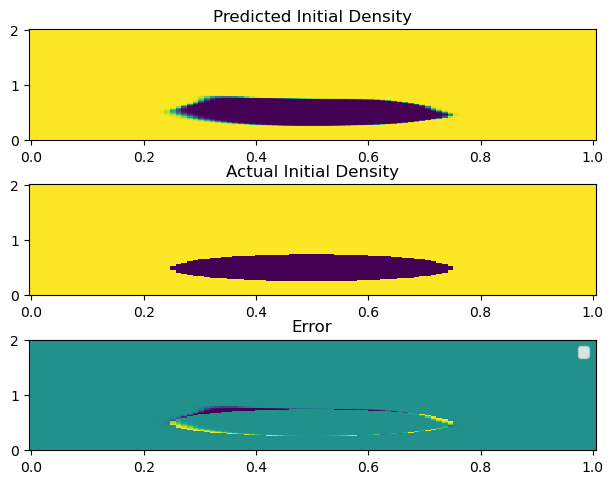

In [1]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from Forward_with_Layer_Setting import Net
from InitialConditionLoss import InitialCondition_rho

###########################################

time_plotted = 0

###########################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net().to(device)

net.load_state_dict(torch.load("IC_Only.pt", map_location=torch.device('cpu')))

#Graph at various time slices

spatial_discretization = 100

#Define numpy arrays for inputs
x1 = np.linspace(net.x1_l,net.x1_u,spatial_discretization).reshape(spatial_discretization)
x2 = np.linspace(net.x2_l,net.x2_u,spatial_discretization).reshape(spatial_discretization)
x1x2 = np.array(np.meshgrid(x1, x2)).reshape(2,spatial_discretization**2)

t = time_plotted*np.ones((spatial_discretization**2,1))

x1_input = x1x2[0].reshape(spatial_discretization**2, 1)
x2_input = x1x2[1].reshape(spatial_discretization**2, 1)

x1x2 = [x1_input, x2_input]

#convert to pytorch tensors
pt_x1 = Variable(torch.from_numpy(x1_input).float(), requires_grad=False).to(device)
pt_x2 = Variable(torch.from_numpy(x2_input).float(), requires_grad=False).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=False).to(device)

#get network outputs
pt_u1, pt_u2, pt_p, pt_rho = net(pt_x1, pt_x2, pt_t)
#pt_rho = pt_rho[:,:1] + pt_rho[:,-1:]

#get actual initial condition
rho_exact = InitialCondition_rho(net, pt_x1, pt_x2)
#rho_exact = rho_exact[:,:1] + rho_exact[:,-1:]
rho_exact = rho_exact

#Convert back to numpy
u1, u2, p, rho = pt_u1.data.cpu().numpy(), pt_u2.data.cpu().numpy(), pt_p.data.cpu().numpy(), pt_rho.data.cpu().numpy()
rho_exact = rho_exact.data.cpu().numpy()
error = rho-rho_exact

X, Y = np.meshgrid(x1, x2)

fig, axs = plt.subplots(3)
#fig.suptitle(f'Time = {time_plotted}')
fig.tight_layout()
axs[0].set_title('Predicted Initial Density')
axs[1].set_title('Actual Initial Density')
axs[2].set_title('Error')
axs[0].pcolor(X, Y, rho.reshape(X.shape))
axs[1].pcolor(X, Y, rho_exact.reshape(X.shape))
axs[2].pcolor(X, Y, error.reshape(X.shape))

plt.legend()
plt.show()